# Album Detail

In [1]:
%run ./wikipedia_setup.ipynb

In [2]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

## Configure DB and Data Accessors

In [3]:
db = sqlite3.Connection("var/data/music.db")

## Load Albums

In [4]:
albums = pd.read_sql("""
    select a.*, adt.AlbumDetailText
    from wp_albums_year_lists a
    left join album_detail_text adt on (
      a.Artist = adt.Artist and
      a.Album = adt.Album
    )
""", db)

## Explore

In [5]:
albums_with_detail_ratio = albums.AlbumDetailText.notnull().mean()
print(f"{albums_with_detail_ratio} of albums have detail content.")

0.8953688859312139 of albums have detail content.


In [6]:
albums['AlbumDetailTextLength'] = albums.AlbumDetailText.apply(lambda t: len(t) if t is not None else 0)

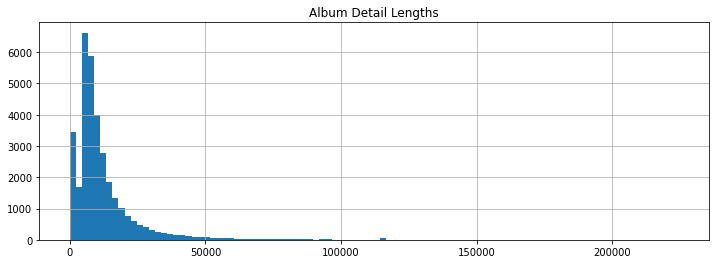

,index,AlbumDetailTextLength
0,count,33059.000000
1,mean,12010.211107
2,std,13300.349963
3,min,0.000000
4,25%,5629.000000
5,50%,8488.000000
6,75%,13922.500000
7,max,224394.000000


In [7]:
a_lens = albums['AlbumDetailTextLength']

plt.figure(figsize=(12, 4))
plt.title("Album Detail Lengths")
plt.hist(a_lens, bins=100)
plt.grid(1)
plt.show()

a_lens.describe().reset_index()

## Process Words

In [8]:
albums['DetailWords'] = albums.AlbumDetailText.fillna('').apply(DetailWords.get_words)

In [9]:
wc = WordCounter()
wc.add_docs(albums['DetailWords'])

In [10]:
word_info = wc.get_word_info()

In [11]:
word_info

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,the,2279741,29600,4.743007,89.536889,0.110486
1,of,822387,29600,1.710978,89.536889,0.110486
2,and,740769,29599,1.541172,89.533864,0.110519
3,album,651303,29565,1.355037,89.431017,0.111669
4,in,643675,29599,1.339167,89.533864,0.110519
...,...,...,...,...,...,...
326872,bisd,1,1,0.000002,0.003025,9.712902
326873,hungriest,1,1,0.000002,0.003025,9.712902
326874,baby-mama,1,1,0.000002,0.003025,9.712902
326875,fragala,1,1,0.000002,0.003025,9.712902


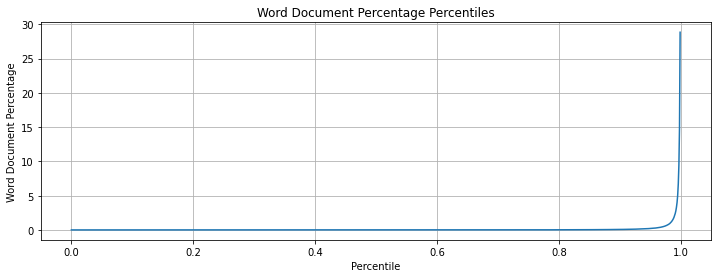

In [12]:
p = np.arange(0, 1, 0.001)
pv = word_info.DocPercent.quantile(p)

plt.figure(figsize=(12, 4))
plt.title("Word Document Percentage Percentiles")
plt.plot(p, pv)
plt.grid(1)
plt.xlabel("Percentile")
plt.ylabel("Word Document Percentage")
plt.show()

## Look at Some Stats On Words

There are so many words in the list. I am not sure that picking a range of those that fall into a doc percentage will give few enough words that TFIDF can be used well.


In [13]:
word_info[word_info.Word.isin({
    "rock",
    "country",
    "rap",
    "hop",
    "country",
    "jazz",
    "groove",
    "elvis",
    "nirvana",
    "psychadelic",
    "goodman"
})].sort_values(by='DocPercent', ascending=False)

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
48,rock,101850,19858,0.211899,60.068363,0.509637
254,country,30013,6465,0.062442,19.555945,1.631736
583,hop,11589,3956,0.024111,11.966484,2.122808
512,jazz,13567,3297,0.028226,9.973078,2.304978
706,rap,9040,2783,0.018808,8.418282,2.474405
1724,groove,2841,1773,0.005911,5.363139,2.925057
716,elvis,8923,907,0.018564,2.743580,3.594805
2796,nirvana,1545,473,0.003214,1.430775,4.244842
4568,goodman,821,426,0.001708,1.288605,4.349265


## Doc2Vec

Since the number of words is so large, I am looking to use doc2vec instead to control the number of features.



In [14]:
docs = []
for _, row in albums.iterrows():
    docs.append(TaggedDocument(row.DetailWords, [f"{row.Artist} - {row.Album}"]))

In [15]:
%%time
doc_model = Doc2Vec(docs, vector_size=50, epochs=10)

2021-10-31 14:40:29,831 - gensim.models.doc2vec - INFO - collecting all words and their counts
2021-10-31 14:40:29,832 - gensim.models.doc2vec - INFO - PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-10-31 14:40:31,529 - gensim.models.doc2vec - INFO - PROGRESS: at example #10000, processed 14179013 words (8360934/s), 175115 word types, 9993 tags
2021-10-31 14:40:33,388 - gensim.models.doc2vec - INFO - PROGRESS: at example #20000, processed 28706323 words (7812347/s), 253172 word types, 19906 tags
2021-10-31 14:40:35,357 - gensim.models.doc2vec - INFO - PROGRESS: at example #30000, processed 43888966 words (7719930/s), 312695 word types, 29813 tags
2021-10-31 14:40:36,047 - gensim.models.doc2vec - INFO - collected 326877 word types and 32841 unique tags from a corpus of 33059 examples and 48065314 words
2021-10-31 14:40:36,048 - gensim.models.word2vec - INFO - Creating a fresh vocabulary
2021-10-31 14:40:36,534 - gensim.utils - INFO - Doc2Vec lifecycle event 

## Save Model

In [16]:
os.makedirs("var/models", exist_ok=True)

In [17]:
doc_model.save("var/models/album_detail_model.d2v")

2021-10-31 14:45:03,426 - gensim.utils - INFO - Doc2Vec lifecycle event {'fname_or_handle': 'var/models/album_detail_model.d2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-10-31T14:45:03.426843', 'gensim': '4.1.2', 'python': '3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
2021-10-31 14:45:03,427 - gensim.utils - INFO - not storing attribute cum_table
2021-10-31 14:45:03,560 - gensim.utils - INFO - saved var/models/album_detail_model.d2v


## Extract Album Embeddings

In [18]:
albums['DetailEmbedding'] = albums.DetailWords.apply(lambda words: doc_model.infer_vector(words))

In [26]:
albums.sample(2)

,id,Artist,Album,Genre,Label,Year,Links,Source,AlbumDetailText,AlbumDetailTextLength,DetailWords,DetailEmbedding
2435,2435,Jason Mraz,Look for the Good,,BMG,2020,"{""Artist"": [{""href"": ""https://en.wikipedia.org...",https://en.wikipedia.org/wiki/List_of_2020_albums,None,0,[],"[-0.0050705243, 0.0005832899, -0.003887983, -0..."
8348,8348,Avicii,True,Folktronica,PRMD Music,2013,"{""Artist"": [{""href"": ""https://en.wikipedia.org...",https://en.wikipedia.org/wiki/List_of_2013_albums,\n \n \n \n True (Avicii album) - Wikipedia \n...,44810,"[true, avicii, album, wikipedia, true, avicii,...","[-0.29066333, -0.30567697, -1.6111428, 1.40536..."


## Save Album Embeddings

In [27]:
albums_save = albums[['Artist', 'Album', 'DetailEmbedding']].copy()
albums_save = albums_save.sort_values(by=['Artist', 'Album']).drop_duplicates(['Artist', 'Album'])
albums_save.DetailEmbedding = albums_save.DetailEmbedding.apply(lambda emb: ",".join(str(x) for x in emb))
albums_save.to_sql("album_embedding", db, if_exists = 'replace', index = False)

In [28]:
cur = db.cursor()
cur.execute(f"""
   create unique index i_album_embedding_k on album_embedding (Artist, Album)
""")
db.commit()
cur.close()